In [10]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE  # For handling imbalanced data

In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE  # For handling imbalanced data

# Load the dataset
file_path = '/content/labeled_data.csv'  # Change this to your file path
data = pd.read_csv(file_path)

# Drop irrelevant columns
data_cleaned = data.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])

# Preprocess the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data_cleaned['tweet'] = data_cleaned['tweet'].apply(preprocess_text)

# Display a sample of preprocessed data
data_cleaned.head()



,class,tweet
0,2,rt as a woman you shouldnt complain about clea...
1,1,rt boy dats coldtyga dwn bad for cuffin dat ho...
2,1,rt dawg rt you ever fuck a bitch and she start...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true or...


In [3]:
# Updated TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words='english')  # Unigrams, bigrams, trigrams
X = tfidf_vectorizer.fit_transform(data_cleaned['tweet']).toarray()
y = data_cleaned['class']

# Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Balance the Dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the shape of balanced data
X_train_balanced.shape, y_train_balanced.shape


((46056, 5000), (46056,))

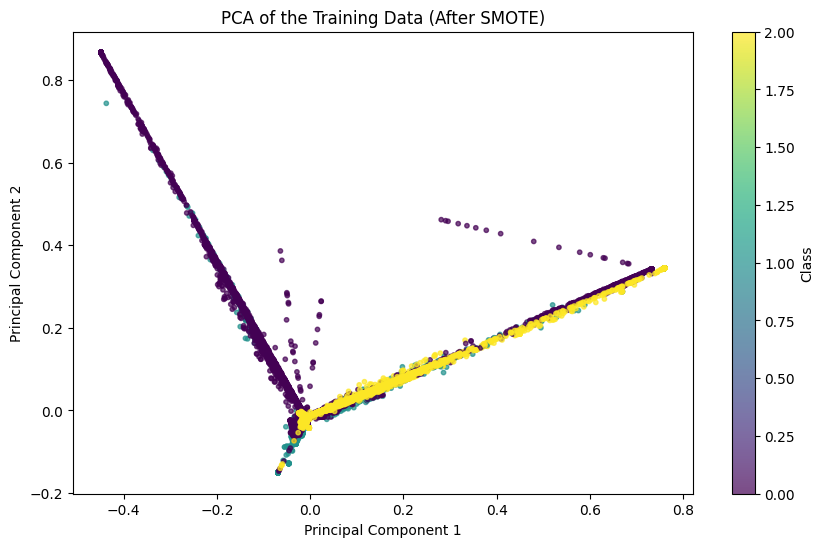

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_balanced)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_balanced, cmap='viridis', s=10, alpha=0.7)
plt.title('PCA of the Training Data (After SMOTE)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class')
plt.show()


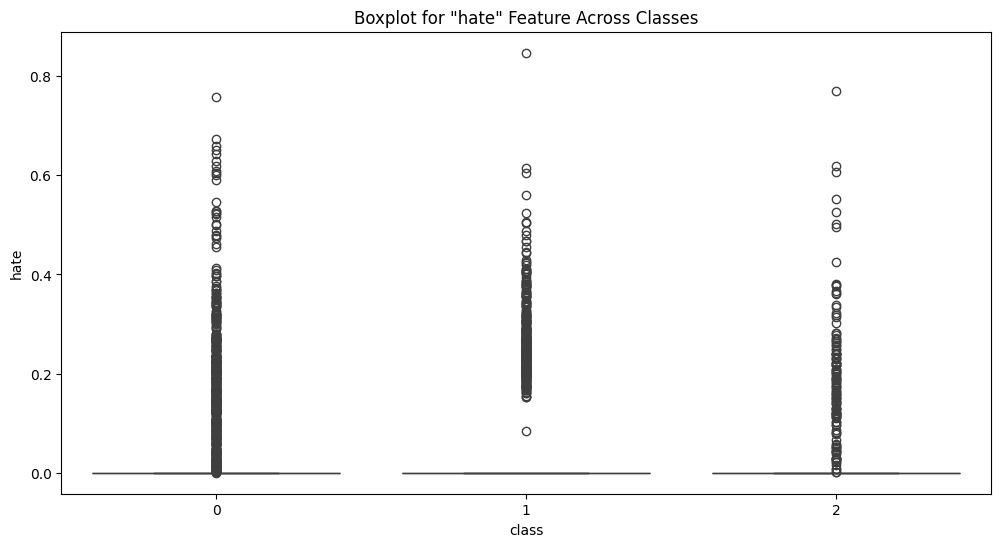

In [13]:
import seaborn as sns
import pandas as pd

# Convert the balanced training data to a DataFrame for visualization
df = pd.DataFrame(X_train_balanced, columns=tfidf_vectorizer.get_feature_names_out())
df['class'] = y_train_balanced

# Boxplot to detect outliers (e.g., for some important feature like the word "hate")
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='hate', data=df)
plt.title('Boxplot for "hate" Feature Across Classes')
plt.show()


In [19]:
import numpy as np

class LogisticRegressionModel:
    def __init__(self, learning_rate=0.05, reg_lambda=0.001, epochs=500):
        """
        Initialize the Logistic Regression model with hyperparameters.
        Args:
            learning_rate (float): Step size for gradient descent.
            reg_lambda (float): L2 regularization strength.
            epochs (int): Number of training iterations.
        """
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.epochs = epochs
        self.weights = None

    def softmax(self, z):
        """
        Compute the softmax probabilities for the given logits.
        Args:
            z (ndarray): Logits (raw scores) matrix of shape (num_samples, num_classes).
        Returns:
            ndarray: Probability matrix of shape (num_samples, num_classes).
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        """
        Compute the cross-entropy loss with L2 regularization.
        Args:
            y_true (ndarray): True labels in one-hot encoded form (shape: num_samples x num_classes).
            y_pred (ndarray): Predicted probabilities (shape: num_samples x num_classes).
        Returns:
            float: Total loss (cross-entropy + regularization term).
        """
        loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-15), axis=1))  # Cross-entropy loss
        reg_term = (self.reg_lambda / 2) * np.sum(self.weights**2)  # L2 regularization term
        return loss + reg_term

    def fit(self, X, y):
        """
        Train the logistic regression model using gradient descent.
        Args:
            X (ndarray): Feature matrix (shape: num_samples x num_features).
            y (ndarray): Target labels (shape: num_samples).
        """
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Initialize weights and convert labels to one-hot encoding
        self.weights = np.zeros((num_features, num_classes))
        y_one_hot = np.eye(num_classes)[y]

        for epoch in range(self.epochs):
            # Compute logits and probabilities
            logits = np.dot(X, self.weights)
            predictions = self.softmax(logits)

            # Compute loss
            loss = self.cross_entropy_loss(y_one_hot, predictions)

            # Compute gradient (with L2 regularization)
            gradient = -np.dot(X.T, (y_one_hot - predictions)) / num_samples
            gradient += self.reg_lambda * self.weights

            # Update weights
            self.weights -= self.learning_rate * gradient

            # Print loss every 50 epochs or on the last epoch
            if epoch % 50 == 0 or epoch == self.epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        """
        Predict class labels for the input data.
        Args:
            X (ndarray): Feature matrix (shape: num_samples x num_features).
        Returns:
            ndarray: Predicted class labels (shape: num_samples).
        """
        logits = np.dot(X, self.weights)
        probabilities = self.softmax(logits)
        return np.argmax(probabilities, axis=1)

lr_model = LogisticRegressionModel()
lr_model.fit(X_train_balanced, y_train_balanced)
y_pred_lr = lr_model.predict(X_test)


Epoch 0, Loss: 1.0986
Epoch 50, Loss: 1.0953
Epoch 100, Loss: 1.0920
Epoch 150, Loss: 1.0888
Epoch 200, Loss: 1.0857
Epoch 250, Loss: 1.0826
Epoch 300, Loss: 1.0795
Epoch 350, Loss: 1.0765
Epoch 400, Loss: 1.0736
Epoch 450, Loss: 1.0707
Epoch 499, Loss: 1.0679


In [20]:
class NaiveBayesModel:
    def __init__(self):
        """
        Initialize the Naive Bayes model.
        """
        self.class_probs = None  # Prior probabilities (P(C_k))
        self.word_probs = None   # Likelihood probabilities (P(x_i | C_k))

    def fit(self, X, y):
        """
        Train the Naive Bayes model by computing prior and likelihood probabilities.
        Args:
            X (ndarray): Feature matrix (shape: num_samples x num_features).
            y (ndarray): Target labels (shape: num_samples).
        """
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Compute class prior probabilities
        y = np.array(y)
        class_counts = np.bincount(y)
        self.class_probs = class_counts / num_samples

        # Initialize matrices for word counts and total word counts per class
        word_counts = np.zeros((num_classes, num_features))
        class_word_counts = np.zeros(num_classes)

        # Calculate word counts for each class
        for i in range(num_samples):
            class_word_counts[y[i]] += X[i].sum()
            word_counts[y[i]] += X[i]

        # Compute likelihood probabilities with Laplace smoothing
        self.word_probs = (word_counts + 1) / (class_word_counts[:, np.newaxis] + num_features)

    def predict(self, X):
        """
        Predict class labels for the input data.
        Args:
            X (ndarray): Feature matrix (shape: num_samples x num_features).
        Returns:
            ndarray: Predicted class labels (shape: num_samples).
        """
        # Compute log of prior and likelihood probabilities for numerical stability
        log_class_probs = np.log(self.class_probs)
        log_word_probs = np.log(self.word_probs)

        # Compute log-posterior probabilities for each class
        log_posterior = X @ log_word_probs.T + log_class_probs

        # Return the class with the highest posterior probability
        return np.argmax(log_posterior, axis=1)


nb_model = NaiveBayesModel()
nb_model.fit(X_train_balanced, y_train_balanced)
y_pred_nb = nb_model.predict(X_test)


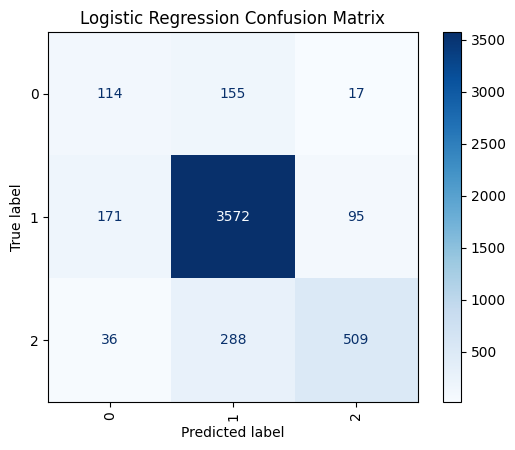

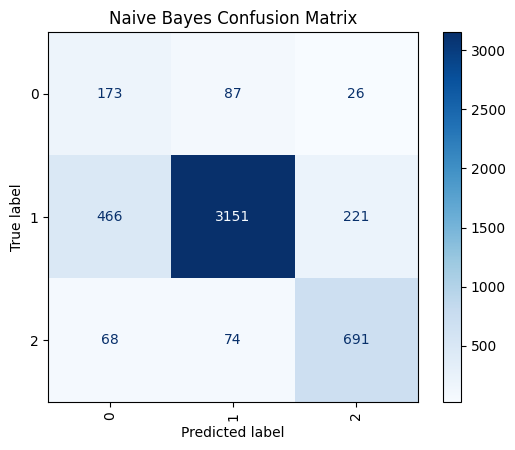

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix Plotting Function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(title)
    plt.show()

# Evaluate Logistic Regression
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")

# Evaluate Naive Bayes
precision_nb = precision_score(y_test, y_pred_nb, average='weighted', zero_division=0)
recall_nb = recall_score(y_test, y_pred_nb, average='weighted', zero_division=0)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted', zero_division=0)
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")


In [22]:
# Results DataFrame
results = pd.DataFrame({
    "Algorithm": ["Logistic Regression", "Naive Bayes"],
    "Precision": [precision_lr, precision_nb],
    "Recall": [recall_lr, recall_nb],
    "F1-Score": [f1_lr, f1_nb]
})

# Display the results
print(results)


             Algorithm  Precision    Recall  F1-Score
0  Logistic Regression   0.847058  0.846278  0.843682
1          Naive Bayes   0.874534  0.809966  0.833668
